In [1]:
import sqlite3

# Database file path
DATABASE_PATH = 'ColivingMaster.db'  # e.g., 'simulated_data.db'

# Connect to the database
conn = sqlite3.connect(DATABASE_PATH)
cursor = conn.cursor()

# Create Tenants table
cursor.execute("""
CREATE TABLE Tenants (
    TenantID INTEGER PRIMARY KEY AUTOINCREMENT,
    Name VARCHAR(100) NOT NULL,
    Email VARCHAR(100) UNIQUE NOT NULL,
    Phone VARCHAR(15),
    MoveInDate DATE NOT NULL,
    MoveOutDate DATE
)
""")

# Create Employees table
cursor.execute("""
CREATE TABLE Employees (
    EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
    Name VARCHAR(100) NOT NULL,
    Role VARCHAR(50) NOT NULL,
    Contact VARCHAR(15)
)
""")

# Create Rooms table
cursor.execute("""
CREATE TABLE Rooms (
    RoomID INTEGER PRIMARY KEY AUTOINCREMENT,
    RoomType VARCHAR(50) NOT NULL,
    Availability BOOLEAN NOT NULL,
    Price DECIMAL(10, 2) NOT NULL,
    EmployeeID INTEGER,
    FOREIGN KEY (EmployeeID) REFERENCES Employees(EmployeeID)
)
""")

# Create Reservations table
cursor.execute("""
CREATE TABLE Reservations (
    ReservationID INTEGER PRIMARY KEY AUTOINCREMENT,
    TenantID INTEGER NOT NULL,
    RoomID INTEGER NOT NULL,
    StartDate DATE NOT NULL,
    EndDate DATE NOT NULL,
    FOREIGN KEY (TenantID) REFERENCES Tenants(TenantID),
    FOREIGN KEY (RoomID) REFERENCES Rooms(RoomID)
)
""")

# Create Events table
cursor.execute("""
CREATE TABLE Events (
    EventID INTEGER PRIMARY KEY AUTOINCREMENT,
    EventName VARCHAR(100) NOT NULL,
    Date DATE NOT NULL,
    Location VARCHAR(100),
    RoomID INTEGER,
    EmployeeID INTEGER,
    StartTime TIME NOT NULL,
    EndTime TIME NOT NULL,
    FOREIGN KEY (RoomID) REFERENCES Rooms(RoomID),
    FOREIGN KEY (EmployeeID) REFERENCES Employees(EmployeeID)
)
""")

# Create Participation table
cursor.execute("""
CREATE TABLE Participation (
    ParticipationID INTEGER PRIMARY KEY AUTOINCREMENT,
    TenantID INTEGER NOT NULL,
    EventID INTEGER NOT NULL,
    Status VARCHAR(20) NOT NULL DEFAULT 'Confirmed',
    FOREIGN KEY (TenantID) REFERENCES Tenants(TenantID),
    FOREIGN KEY (EventID) REFERENCES Events(EventID)
)
""")

conn.commit()
cursor.close()
conn.close()

print("Tables created!")

Tables created!


In [2]:
!pip install Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.7 MB/s eta 0:00:00


In [3]:
from faker import Faker
import sqlite3
import random
import numpy as np
from datetime import datetime, timedelta

# Initialize Faker
fake = Faker()

# Database connection
DATABASE_PATH = 'ColivingMaster.db'
conn = sqlite3.connect(DATABASE_PATH)
cursor = conn.cursor()

def random_date_poisson(start_date, mean):
    days = np.random.poisson(mean)
    return start_date + timedelta(days=int(days))

def random_date_exponential(start_date, mean):
    days = np.random.exponential(mean)
    return start_date + timedelta(days=int(days))

def random_time():
    hour = random.randint(9, 20)
    minute = random.randint(0, 59)
    return f"{hour:02}:{minute:02}"

# Insert data into Tenants
def insert_tenants(n):
    tenants = []
    reference_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
    for _ in range(n):
        name = fake.name()
        email = fake.unique.email()
        phone = fake.phone_number()
        move_in_date = random_date_poisson(reference_date, 30)
        move_out_date = random_date_exponential(move_in_date, 180) if random.random() > 0.5 else None
        tenants.append((name, email, phone, move_in_date, move_out_date))
    cursor.executemany("""
    INSERT INTO Tenants (Name, Email, Phone, MoveInDate, MoveOutDate)
    VALUES (?, ?, ?, ?, ?)
    """, tenants)
    conn.commit()

# Insert data into Employees
def insert_employees(n):
    employees = []
    roles = ['Manager', 'Cleaner', 'Receptionist', 'Technician']
    role_probabilities = [0.1, 0.3, 0.2, 0.4]
    for _ in range(n):
        name = fake.name()
        role = random.choices(roles, weights=role_probabilities, k=1)[0]
        contact = fake.phone_number()
        employees.append((name, role, contact))
    cursor.executemany("""
    INSERT INTO Employees (Name, Role, Contact)
    VALUES (?, ?, ?)
    """, employees)
    conn.commit()

# Insert data into Rooms
def insert_rooms(n):
    rooms = []
    room_types = ['Single', 'Double', 'Suite']
    type_probabilities = [0.5, 0.35, 0.15]
    for _ in range(n):
        room_type = random.choices(room_types, weights=type_probabilities, k=1)[0]
        availability = random.choices([True, False], weights=[0.7, 0.3], k=1)[0]
        mean_price = {'Single': 150, 'Double': 310, 'Suite': 500}[room_type]
        price = round(np.random.normal(mean_price, mean_price * 0.1), 2)
        employee_id = random.randint(1, 10) if random.random() > 0.5 else None
        rooms.append((room_type, availability, price, employee_id))
    cursor.executemany("""
    INSERT INTO Rooms (RoomType, Availability, Price, EmployeeID)
    VALUES (?, ?, ?, ?)
    """, rooms)
    conn.commit()

# Insert data into Reservations
def insert_reservations(n):
    reservations = []
    reference_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
    for _ in range(n):
        tenant_id = random.randint(1, 20)
        room_id = random.randint(1, 15)
        start_date = random_date_poisson(reference_date, 30)
        end_date = random_date_exponential(start_date, 7)
        reservations.append((tenant_id, room_id, start_date, end_date))
    cursor.executemany("""
    INSERT INTO Reservations (TenantID, RoomID, StartDate, EndDate)
    VALUES (?, ?, ?, ?)
    """, reservations)
    conn.commit()

# Insert data into Events
def insert_events(n):
    events = []
    reference_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
    for _ in range(n):
        event_name = fake.catch_phrase()
        date = random_date_poisson(reference_date, 15)
        location = fake.address()
        room_id = random.randint(1, 15)
        employee_id = random.randint(1, 10)
        start_time = random_time()
        end_time = random_time()
        while end_time <= start_time:
            end_time = random_time()
        events.append((event_name, date, location, room_id, employee_id, start_time, end_time))
    cursor.executemany("""
    INSERT INTO Events (EventName, Date, Location, RoomID, EmployeeID, StartTime, EndTime)
    VALUES (?, ?, ?, ?, ?, ?, ?)
    """, events)
    conn.commit()

# Insert data into Participation
def insert_participation(n):
    participation = []
    statuses = ['Confirmed', 'Pending', 'Cancelled']
    status_probabilities = [0.7, 0.2, 0.1]
    for _ in range(n):
        tenant_id = random.randint(1, 20)
        event_id = random.randint(1, 10)
        status = random.choices(statuses, weights=status_probabilities, k=1)[0]
        participation.append((tenant_id, event_id, status))
    cursor.executemany("""
    INSERT INTO Participation (TenantID, EventID, Status)
    VALUES (?, ?, ?)
    """, participation)
    conn.commit()

insert_tenants(150)
insert_employees(75)
insert_rooms(50)
insert_reservations(1000)
insert_events(25)
insert_participation(45)

# Close connection
cursor.close()
conn.close()

print("Mock data inserted successfully!")


Mock data inserted successfully!


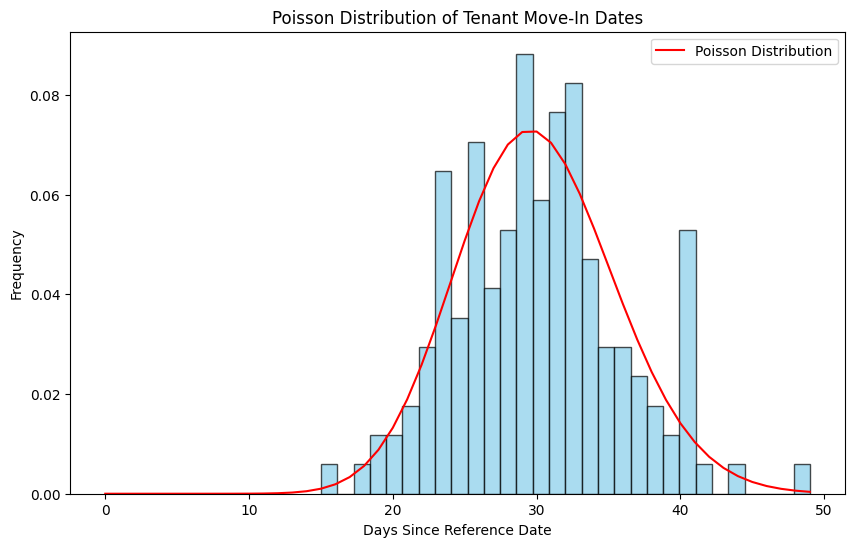

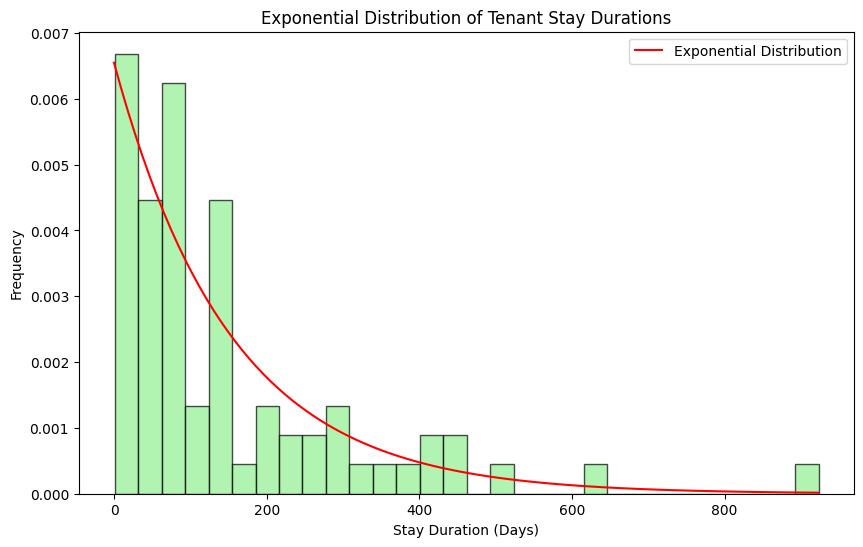

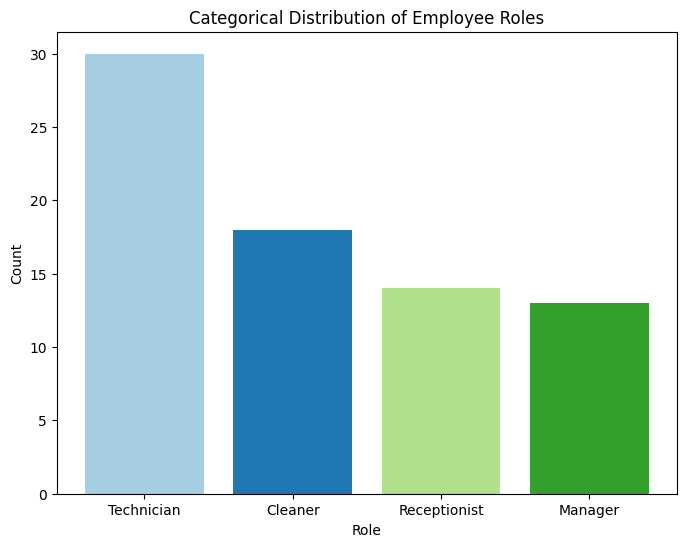

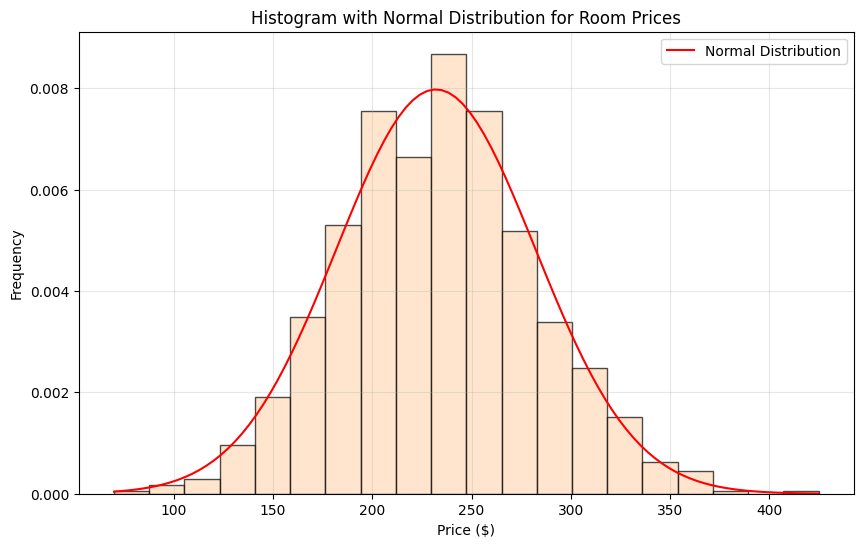

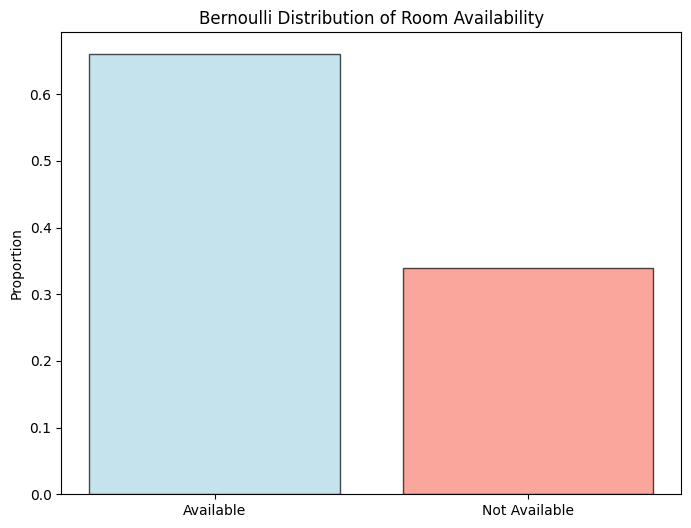

Distribution visualizations generated successfully!


In [4]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import factorial

conn = sqlite3.connect(DATABASE_PATH)

tenants_df = pd.read_sql_query("SELECT * FROM Tenants", conn)
employees_df = pd.read_sql_query("SELECT * FROM Employees", conn)
rooms_df = pd.read_sql_query("SELECT * FROM Rooms", conn)
reservations_df = pd.read_sql_query("SELECT * FROM Reservations", conn)
events_df = pd.read_sql_query("SELECT * FROM Events", conn)
participation_df = pd.read_sql_query("SELECT * FROM Participation", conn)

# Poisson Distribution for Tenant Move-In Dates
reference_date = pd.to_datetime('2023-01-01')
move_in_dates = pd.to_datetime(tenants_df['MoveInDate'])
days_since_reference = (move_in_dates - reference_date).dt.days
days_since_reference = days_since_reference[days_since_reference >= 0]
plt.figure(figsize=(10, 6))
plt.hist(days_since_reference, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)
mean_days = days_since_reference.mean()
x = np.arange(0, days_since_reference.max() + 1)
y = (np.exp(-mean_days) * np.power(mean_days, x)) / factorial(x)
plt.plot(x, y, 'r-', label='Poisson Distribution')
plt.title('Poisson Distribution of Tenant Move-In Dates')
plt.xlabel('Days Since Reference Date')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Exponential Distribution for Tenant Move-Out Dates
move_out_dates = pd.to_datetime(tenants_df['MoveOutDate']).dropna()
stay_duration = (move_out_dates - move_in_dates).dt.days.dropna()
plt.figure(figsize=(10, 6))
plt.hist(stay_duration, bins=30, color='lightgreen', edgecolor='black', alpha=0.7, density=True)
mean_stay = stay_duration.mean()
x = np.linspace(0, stay_duration.max(), 100)
y = (1/mean_stay) * np.exp(-x / mean_stay)
plt.plot(x, y, 'r-', label='Exponential Distribution')
plt.title('Exponential Distribution of Tenant Stay Durations')
plt.xlabel('Stay Duration (Days)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Categorical Distribution for Employee Roles
role_counts = employees_df['Role'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(role_counts.index, role_counts.values, color=plt.cm.Paired.colors)
plt.title('Categorical Distribution of Employee Roles')
plt.xlabel('Role')
plt.ylabel('Count')
plt.show()

# Normal Distribution for Room Prices
room_prices = rooms_df['Price']
np.random.seed(42)
mean_price = room_prices.mean()
std_dev_price = 50
sample_size = 1000
synthetic_prices = np.random.normal(mean_price, std_dev_price, sample_size)
plt.figure(figsize=(10, 6))
plt.hist(synthetic_prices, bins=20, color='peachpuff', edgecolor='black', alpha=0.7, density=True)
x = np.linspace(synthetic_prices.min(), synthetic_prices.max(), 100)
y = (1 / (std_dev_price * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean_price) / std_dev_price) ** 2)
plt.plot(x, y, 'r-', label='Normal Distribution')
plt.title('Histogram with Normal Distribution for Room Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Bernoulli Distribution for Room Availability
availability_counts = rooms_df['Availability'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
plt.bar(['Available', 'Not Available'], availability_counts.values, color=['lightblue', 'salmon'], edgecolor='black', alpha=0.7)
plt.title('Bernoulli Distribution of Room Availability')
plt.ylabel('Proportion')
plt.show()

conn.close()
print("Distribution visualizations generated successfully!")
